In [41]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style(style="whitegrid")
sns.set_color_codes()

Я понял так, что первые 12 признаков, в полученой таблице, у нас описательные, а все остальные целевые. Если это не соответствует действительности, то все что написано дальше можно не читать.

Для предварительной простоты примем задачу в которой нам нужно по 12 признакам предсказать какое отношение будет иметь человек к целевому признаку напрмер 24 (один мой знакомец, по студенчеству, был героиновым наркоманом). 

В признаке 24 есть следующие классы:
CL0 Никогда не употреблял,
CL2 Использовал в последнее десятилетие, 
CL3 Использовал в прошлом году, 
CL4 Использовал в прошлом месяце, 
CL5 Использовал на прошлой неделе, 
CL6 Использовал в последний день.

In [42]:
data=pd.read_csv('drug_consumption.data',  header=None, index_col=0)
# удалим целевые признаки с которыми не работаем
data.drop(columns=[13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,30,31], axis=1, inplace=True)
data.head()

,1,2,3,4,5,6,7,8,9,10,11,12,24
0,,,,,,,,,,,,,
1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,CL0
2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,CL2
3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,CL0
4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,CL2
5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,CL0


In [43]:
# посмотрим на признаки
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1885 entries, 1 to 1888
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       1885 non-null   float64
 1   2       1885 non-null   float64
 2   3       1885 non-null   float64
 3   4       1885 non-null   float64
 4   5       1885 non-null   float64
 5   6       1885 non-null   float64
 6   7       1885 non-null   float64
 7   8       1885 non-null   float64
 8   9       1885 non-null   float64
 9   10      1885 non-null   float64
 10  11      1885 non-null   float64
 11  12      1885 non-null   float64
 12  24      1885 non-null   object 
dtypes: float64(12), object(1)
memory usage: 206.2+ KB


In [44]:
data.nunique()

1      6
2      2
3      9
4      7
5      7
6     49
7     42
8     35
9     41
10    41
11    10
12    11
24     7
dtype: int64

В описании к задаче указано: "После количественной оценки значения всех входных признаков можно считать вещественными", я бы усомнился... 2Пол, 3образование, 4страна, 5этнос - как ни крути остаются категориальными, 1Age, 6Neuroticism, 7Extraversion, 8Openness, 9Agreeableness, 10Conscientiousness, 11impulsiveness, 12sensation - по описанию скорее порядковые. Посмотрим на признаки.

Обращаем внимание на то что классы не сбалансированы.

In [45]:

data[24].value_counts()

CL0    1490
CL2     142
CL3     129
CL1      45
CL4      42
CL5      33
CL6       4
Name: 24, dtype: int64

<AxesSubplot:xlabel='24', ylabel='Count'>

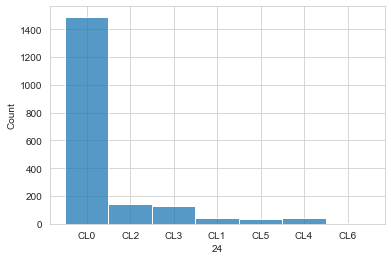

In [46]:
sns.histplot(data[24])

...ну будто бы "не плохо"/умерено положительно коррелирут 11 и 12 признаки, честно сказать не вижу что из этоно можно извлечь..., скорее/пока взять на карандаш...(последующие эксперименты покаазли, что отказ от любого из них приводит к ухудшению качества любой модели)

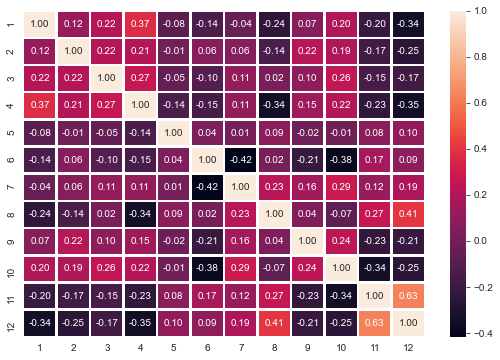

In [47]:
#  корреляции признаков
corr = data.corr(method='spearman')
f,ax = plt.subplots(figsize=(9,6))
sns.heatmap(corr, annot = True, linewidths=1.5 , fmt = '.2f',ax=ax)
plt.show()

Смотрим гистоплоты по всем фичам и видим 2,4,12 - чисто, 1,3,5,6,7,8,9,10,11 - могут быть выбросы. Кроме того, распределения данных нельзя считать нормальными, хотя некоторые быть может и близки (все гистограммы не вывожу, слишком загромождают ноутбук, досттаточно глазками посмотреть 1 раз, сделать выводы и пометки).

<AxesSubplot:xlabel='8', ylabel='Count'>

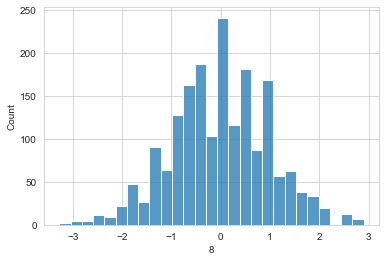

In [48]:
sns.histplot(data[8])

Попробуем найти/оценить выбросы в наших данных.

In [49]:
# Опишем функцию построения доверительного интервала (хотя мне кажется это по другому называется)
def confid_int(data, alfa):        
    #вариант с сигмами
    #x_min=round(data.mean()-alfa*statistics.stdev(data))
    #x_max=round(data.mean()+alfa*statistics.stdev(data))  
    # Выбираем непараметрику - вариант с процентилями
    a=1.5
    q25=data.quantile(0.25)
    q75=data.quantile(0.75)
    iqr=q75-q25
    x_min=q25-a*iqr
    x_max=q75+a*iqr
    return(x_min, x_max, round(data.median()))

In [50]:
# найдем все строки в данных которые причисляются к выбросам
out_data=pd.DataFrame()
for i in range(1,data.shape[1]):
    ci=confid_int(data[i], 3)
    out_data=out_data.append(data[data[i]<ci[0]])
    out_data=out_data.append(data[data[i]>ci[1]])
# удалим повторяющиеся
out_data=out_data.drop_duplicates()
out_data.shape

(265, 13)

"В лоб" получается что в наших 1885 записях 265 выбросов... Много! Жалко! можно попорбовать, по результатам работы моделей, поколдовать с коэфицентом а=1.5.... (по результатам работы моделей 1,5 оптимально, уменьшение и увеличее этого коэфицента приводит к ухудшению качества модели, кроме того обращаем внимание на то, что после отказа от выбросов в данных у нас фактически отвалилась 5 фича и действительно если посмотреть на ее структуру то окажется что наши данные собраны в основном (91.25%) для светлокожего населения, т.е. других/остальных (ососбенно посомтря на распределение) нет смысла рассматривать)

In [51]:
# удалим из данных найденые выбросы
data=data[np.logical_not(data.isin(out_data))].dropna()

Еще раз, после чистки, посмтрим на распределение в целевой переменной.

<AxesSubplot:xlabel='24', ylabel='Count'>

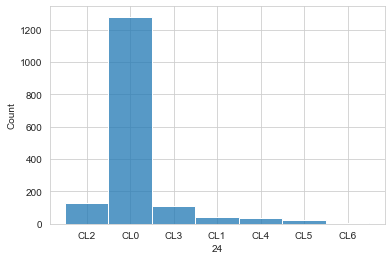

In [52]:
sns.histplot(data[24])

In [53]:
data[24].value_counts()

CL0    1280
CL2     128
CL3     108
CL1      40
CL4      36
CL5      24
CL6       4
Name: 24, dtype: int64

Усомнимся в нормализованности наших данных. Да, действительно не будет лишним нормализовать вещественные данные нашего датафрейма.

In [54]:
data.describe()

,1,2,3,4,5,6,7,8,9,10,11,12
count,1620.000000,1.620000e+03,1620.000000,1620.000000,1.620000e+03,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000
mean,0.063028,-6.853229e-20,0.027249,0.384584,-3.168500e-01,-0.018586,0.012942,-0.011997,0.007431,0.008713,-0.019993,-0.020086
std,0.876790,4.826090e-01,0.908533,0.691895,8.440300e-15,0.955818,0.943952,0.975434,0.978008,0.940901,0.942329,0.947080
min,-0.951970,-4.824600e-01,-1.737900,-0.570090,-3.168500e-01,-2.521970,-2.538300,-2.859500,-2.538300,-2.423170,-2.555240,-2.078480
25%,-0.951970,-4.824600e-01,-0.611130,-0.570090,-3.168500e-01,-0.678250,-0.575450,-0.717270,-0.606330,-0.652530,-0.711260,-0.525930
50%,-0.078540,0.000000e+00,-0.059210,0.960820,-3.168500e-01,-0.051880,0.003320,-0.019280,-0.017290,-0.006650,-0.217120,0.079870
75%,0.497880,4.824600e-01,0.454680,0.960820,-3.168500e-01,0.629670,0.637790,0.723300,0.590420,0.584890,0.529750,0.765400
max,2.591710,4.824600e-01,1.984370,0.960820,-3.168500e-01,2.462620,2.573090,2.449040,2.756960,2.333370,1.862030,1.921730


Станем считать что признаки 2,3,4,5 - категориальные, остальные вещественные. Перекодируем наши категориальные признаки и нормализуем вещественные данные.

In [55]:
#X=data.drop(columns=[24], axis=1)
#y=data[24]
#x_temp=X[[2,3,4,5]].astype(str)
#x_temp=pd.get_dummies(x_temp, prefix_sep='_', drop_first=True)
#X.drop(columns=[2,3,4,5], axis=1, inplace=True)
#X=pd.concat([X,x_temp], axis=1)


In [56]:
from sklearn import preprocessing
X=data.drop(columns=[24], axis=1).astype('float')
y=data[24]
x_temp=X[[2,3,4,5]].astype(str)
x_temp=pd.get_dummies(x_temp, prefix_sep='_', drop_first=True)
X.drop(columns=[2,3,4,5], axis=1, inplace=True)
# нормализуем вещ.данные
scaler = preprocessing.MinMaxScaler()
d = scaler.fit_transform(X)
X = pd.DataFrame(d)
# след.две строки нормализуют перекодированные данные, по сути ничего не меняют, но позволяют
# потом без проблем/корректно pd.concat вещественные и категориальные фичи 
d = scaler.fit_transform(x_temp)
x_temp = pd.DataFrame(d)

X=pd.concat([X,x_temp], axis=1)

Разобъемся на обучающий и тестовый наборы

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Выровняем/сбалансируем классы. Принимая во внимание численность "малых классов", решаем "дотягивать" их до значения доминирующего класаа CL0. Выравнивать классы будем только на обучающей выборке, если сделать это на всех данных - есть шанс того, что модель будет учится на тех данных которые потом будет предсказывать в тестовом наборе (столкнемся с проблемой переобучения).

In [58]:
X_train[24]=y_train
# опишем функцию передискретизации одного класса до (желаемого) объема класса not_fraud
from sklearn.utils import resample
def resam(not_fraud, fraud):
    fraud_upsample=resample(fraud, replace=True, n_samples=len(not_fraud), random_state=27)
    return fraud_upsample
X_desc=pd.DataFrame()
# Соберем наши дополненные классы в один dataframe
X_desc=pd.concat([
    X_train[X_train[24]=='CL0'],
    resam(X_train[X_train[24]=='CL0'], X_train[X_train[24]=='CL1']),
    resam(X_train[X_train[24]=='CL0'], X_train[X_train[24]=='CL2']),
    resam(X_train[X_train[24]=='CL0'], X_train[X_train[24]=='CL3']),
    resam(X_train[X_train[24]=='CL0'], X_train[X_train[24]=='CL4']),
    resam(X_train[X_train[24]=='CL0'], X_train[X_train[24]=='CL5']),
    resam(X_train[X_train[24]=='CL0'], X_train[X_train[24]=='CL6']) 
    ])
y_train=X_desc[24]
X_train=X_desc.drop(columns=[24], axis=1)
# чорт!!!, уверен/знаю что можно как-то изящнее все это сделать, но к ночи ближе начинаю плохо соображать

<ipython-input-58-fb0804928bb6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[24]=y_train


Обучим модели на известных нам алгоритмах (на дефолтных параметрах). Первичные метрики оценки качества (accuracy) по каждой модели будем складывать в отдельный dataframe.

In [59]:

accuracy=pd.DataFrame()

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
clf = OneVsRestClassifier(LinearSVC(random_state=0)).fit(X_train, y_train)
accuracy['OVRest']=[clf.score(X_train, y_train),clf.score(X_test, y_test)]

from sklearn.multiclass import OneVsOneClassifier
clf = OneVsOneClassifier(LinearSVC(random_state=0)).fit(X_train, y_train)
accuracy['OVOne']=[clf.score(X_train, y_train),clf.score(X_test, y_test)]

from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors = 2 ).fit(X_train, y_train)
accuracy['Kneigh']=[clf.score(X_train, y_train),clf.score(X_test, y_test)]

from sklearn.multiclass import OutputCodeClassifier
clf = OutputCodeClassifier(LinearSVC(random_state=0),code_size=2, random_state=0).fit(X_train, y_train) #???
accuracy['OCode']=[clf.score(X_train, y_train),clf.score(X_test, y_test)]

from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, y_train)
accuracy['GradB']=[clf.score(X_train, y_train),clf.score(X_test, y_test)]

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, multi_class='ovr').fit(X_train, y_train)
accuracy['LR']=[clf.score(X_train, y_train),clf.score(X_test, y_test)]

from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
accuracy['DTree']=[clf.score(X_train, y_train),clf.score(X_test, y_test)]

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import ExtraTreeClassifier
extra_tree = ExtraTreeClassifier(random_state=0)
clf = BaggingClassifier(extra_tree, random_state=0).fit(X_train, y_train)
accuracy['ETree']=[clf.score(X_train, y_train),clf.score(X_test, y_test)]

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier().fit(X_train, y_train)
accuracy['RForest']=[clf.score(X_train, y_train),clf.score(X_test, y_test)]


Видим что неплохо показывают себя деревья, в частности RandomForestClassifier.

In [60]:
accuracy.rename({0:"accuracy_Train", 1:"accuracy_Test"}, inplace=True)
accuracy

,OVRest,OVOne,Kneigh,OCode,GradB,LR,DTree,ETree,RForest
accuracy_Train,0.523887,0.620826,1.000000,0.434833,0.834184,0.514147,1.000000,1.000000,1.000000
accuracy_Test,0.212346,0.256790,0.632099,0.130864,0.353086,0.207407,0.634568,0.753086,0.797531


Подберем параметр n_estimators 

In [64]:
from sklearn.ensemble import RandomForestClassifier

# Создаём модель леса из сотни деревьев
accuracy=pd.Series(np.zeros((200)))
k=0
for i in range(1,200):
    clf = RandomForestClassifier(n_estimators=i).fit(X_train, y_train)
    prediction=clf.predict(X_test)
    accuracy[i]=clf.score(X_test, y_test)
    if accuracy[i-1]>accuracy[i]: k=i
print('Максимальное значение accurecy=',  round(accuracy.max(),5), ' достигается при параметре n_estimators=',k)

Максимальное значение accurecy= 0.79753  достигается при параметре n_estimators= 197


Видим что при значении n_estimators>75 accuracy практически вытягивается в линию

Text(0, 0.5, 'accuracy')

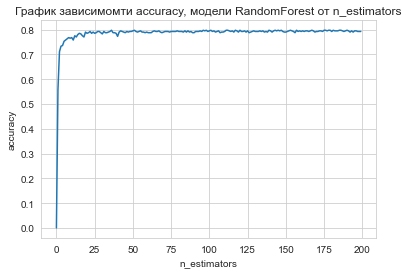

In [66]:
plt.plot(accuracy)
plt.title('График зависимомти accuracy, модели RandomForest, от n_estimators') 
plt.xlabel('n_estimators')
plt.ylabel('accuracy')



Посмотрим насколько изменится accuracy если мы воспользуемся кросс валидацией

In [73]:
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier(n_estimators=197).fit(X_train, y_train)
scores = cross_val_score(clf, X_test, y_test, cv=5)
prediction=clf.predict(X_test)
scores.mean()

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


0.7950617283950617

Выведем финальные оценки работы нашей модели.

In [75]:
from sklearn import metrics
print(metrics.classification_report(y_test, prediction, digits=3))

              precision    recall  f1-score   support

         CL0      0.800     1.000     0.889       323
         CL1      0.000     0.000     0.000        10
         CL2      0.000     0.000     0.000        31
         CL3      0.000     0.000     0.000        29
         CL4      0.000     0.000     0.000         4
         CL5      0.000     0.000     0.000         8

    accuracy                          0.798       405
   macro avg      0.133     0.167     0.148       405
weighted avg      0.638     0.798     0.709       405



C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


__Финальные выводы__: мне не нравится, я не доволен!!!, 0,8 на мой взгляд недостойно мало, к тому же по сути наша модель научилась находить только CL0, ...остальные классы конечно "так себе" представлены, но тем не менее... Итак, если руководство/заказчик/тимлид говорит нам что это "максимум", то переписываем код с учетом того, что предсказаний должно быть 18. Может быть можно и "одним гуртом", но я бы, после всех предварительных обработок данных, зарядил цикл в котором мы последовательно работаем с каждой из 18-ти целевых переменных, соответственно в каждой определяем доминирующий класс, дотягиваем отстающие классы, прогоняем модели, результаты сваливаем в табличку, анализируем ее и по необходимости работаем/дорабатываем "индивидуально каждую целевую фичу". Я бы еще все это обернул в классы, мне кажется будет нагляднее и легче работать.

__Забавно, что если вообще ничего не делать с данными, а просто в чистом виде зарядить их в алгоритмы, то "сырые" результата получаются совсем не хуже, а местами даже лучше. У меня все-таки есть ощущение что я чего-то не уловил..., есть какая-то великая/невеликая хитрость которая мне не открылась...__

In [77]:
X=data.drop(columns=[24], axis=1).astype('float')
y=data[24]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
accuracy=pd.DataFrame()

clf = OneVsRestClassifier(LinearSVC(random_state=0)).fit(X_train, y_train)
accuracy['OVRest']=[clf.score(X_train, y_train),clf.score(X_test, y_test)]
clf = OneVsOneClassifier(LinearSVC(random_state=0)).fit(X_train, y_train)
accuracy['OVOne']=[clf.score(X_train, y_train),clf.score(X_test, y_test)]
clf = KNeighborsClassifier(n_neighbors = 2 ).fit(X_train, y_train)
accuracy['Kneigh']=[clf.score(X_train, y_train),clf.score(X_test, y_test)]
clf = OutputCodeClassifier(LinearSVC(random_state=0),code_size=2, random_state=0).fit(X_train, y_train) #???
accuracy['OCode']=[clf.score(X_train, y_train),clf.score(X_test, y_test)]
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, y_train)
accuracy['GradB']=[clf.score(X_train, y_train),clf.score(X_test, y_test)]
clf = LogisticRegression(random_state=0, multi_class='ovr').fit(X_train, y_train)
accuracy['LR']=[clf.score(X_train, y_train),clf.score(X_test, y_test)]
clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
accuracy['DTree']=[clf.score(X_train, y_train),clf.score(X_test, y_test)]
extra_tree = ExtraTreeClassifier(random_state=0)
clf = BaggingClassifier(extra_tree, random_state=0).fit(X_train, y_train)
accuracy['ETree']=[clf.score(X_train, y_train),clf.score(X_test, y_test)]
clf = RandomForestClassifier().fit(X_train, y_train)
accuracy['RForest']=[clf.score(X_train, y_train),clf.score(X_test, y_test)]
accuracy.rename({0:"accuracy_Train", 1:"accuracy_Test"}, inplace=True)
accuracy


,OVRest,OVOne,Kneigh,OCode,GradB,LR,DTree,ETree,RForest
accuracy_Train,0.787654,0.787654,0.82716,0.787654,0.792593,0.787654,1.000000,0.974486,1.000000
accuracy_Test,0.797531,0.797531,0.77037,0.797531,0.777778,0.797531,0.634568,0.787654,0.797531
